In [28]:
# Imports
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_leon
import vidutils_leon

# Create Training and Test Sets

In [29]:
# Define label dictionary - 20 classes
syncs = [  "0-50 ms",   "51-100 ms", "101-150 ms", "151-200 ms", "201-250 ms",
         "251-300 ms", "301-350 ms", "351-400 ms", "401-450 ms", "451-500 ms", 
         "501-550 ms", "551-600 ms", "601-650 ms", "651-700 ms", "701-750 ms", 
         "751-800 ms", "801-850 ms", "851-900 ms", "901-950 ms", "951-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-50 ms': 0,
 '51-100 ms': 1,
 '101-150 ms': 2,
 '151-200 ms': 3,
 '201-250 ms': 4,
 '251-300 ms': 5,
 '301-350 ms': 6,
 '351-400 ms': 7,
 '401-450 ms': 8,
 '451-500 ms': 9,
 '501-550 ms': 10,
 '551-600 ms': 11,
 '601-650 ms': 12,
 '651-700 ms': 13,
 '701-750 ms': 14,
 '751-800 ms': 15,
 '801-850 ms': 16,
 '851-900 ms': 17,
 '901-950 ms': 18,
 '951-1000 ms': 19}

### Load real edited videos
Define classes and preview

In [87]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


(504,
 504,
 Counter({3: 50,
          4: 50,
          6: 48,
          1: 54,
          5: 51,
          8: 52,
          2: 49,
          9: 52,
          0: 48,
          7: 50}))

### Load synthetically created feature points
Define classes and preview

In [45]:
# define synthetic data directory
output_dir = 'synthetic_data/output'
output_list = os.listdir(output_dir)

X_paths = [] # paths of segment folders
y = [] # designated label

for output_folder in output_list:
    if output_folder.startswith('vid'):
        x_path = output_dir + '/' + output_folder
        X_paths.append(x_path)
        
        # Extract class label from folder name
        params = re.findall(r'\d+', output_folder)
        label = int( (int(params[3]) - 1) / 100)
        y.append(label)
        
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        # extract features
        num_frames = 20
        X_feat = vidutils_leon.reshape_syn_features \
        (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

(854,
 854,
 Counter({0: 86,
          7: 85,
          4: 85,
          9: 84,
          1: 84,
          8: 86,
          6: 85,
          3: 86,
          5: 86,
          2: 87}))

Combine synthetic and real data

In [55]:
X_paths = [] # paths of segment folders
y = [] # designated label

# Specify directories
frame_folder = "./data/frames"
# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)
print(vf_list)

for vf_folder in vf_list:
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path + '/features.npz')
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
        
# define synthetic data directory
output_dir = './synthetic_data/output'
output_list = os.listdir(output_dir)

for output_folder in output_list:
    if output_folder.startswith('vid'):
        x_path = output_dir + '/' + output_folder
        X_paths.append(x_path)
        
        # Extract class label from folder name
        params = re.findall(r'\d+', output_folder)
        label = int( (int(params[3]) - 1) / 100)
        y.append(label)
        
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils_leon.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

['video3', 'video4', 'video2', 'video1']
Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


(1358,
 1358,
 Counter({3: 136,
          4: 135,
          6: 133,
          1: 138,
          5: 137,
          8: 138,
          2: 136,
          9: 136,
          0: 134,
          7: 135}))

# Create Pytorch Dataset
## Load data
Split into training and test (apply transform if applicable)

In [88]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


In [89]:
# define normalization
class norm_per_keypt(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=1)
        sub2 = normalize(sample[:,56:112], axis=1)
        sub3 = normalize(sample[:,112:168], axis=1)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample
    
class norm_over_frames(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample, axis=1)
        return scaled_sample
    
class norm_over_all(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample)
        return scaled_sample

class norm_with_saved(object):
    """
    Rescale so features are between 0 and 1 for each subject
    Important: Calculate saved_mean and saved_std first.

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [90]:
# precalculate means and std
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0) 
saved_std[saved_std == 0] = 0.00001 # prevent error dividing by 0

# Define Transformer
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor()
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

In [91]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y
sample_X[2,3:6]

tensor([ 1.3554,  1.4152, -0.1980])

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [92]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [93]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 

In [94]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168 #108 #168
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        
        return output

# Model Training  

Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   8   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |
|   9   |  real  |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      7.8    |     7.8   |
|   10  |r_inorm |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      9.8    |     9.8   |
|   11  |r_fnorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 8.3   |      9.8    |     9.8   |
|   12  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |   CE: 1.5   |      40     |     19    |
|   13  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 1.5   |      23     |     23.5  |
|   14  |r_snorm |   0  |    1     |      100      |    200   |  0.1   |   CE: 1.4   |      50     |     23    |
|   15  |r_snorm |   0  |    1     |      200      |    200   |  0.1   |   CE: 1.4   |      50     |     20    |
|   16  |r_snorm |   0  |    2     |      100      |    200   |  0.1   |   CE: 1.5   |      35     |     20    |
|   17  |s_snorm |   0  |    1     |      100      |    200   |  0.1   |   CE: 1.5   |      35     |     20    |
|   18  |sr_snorm|   0  |    1     |      100      |    200   |  0.1   |   CE: 1.8   |      35     |     15    |
|   19  |sr_snorm|   0  |    1     |      100      |    200   |  0.1   |   MSE:6.7   |      14     |     14    |
|   20  |sr_snorm|   0  |    1     |      100      |    200   |  0.1   |   L1: 2.2   |      14     |     14    |
|   21  |  real  |   0  |    1     |      100      |    200   |  0.1   |   L1: 1.25  |      25     |     35    |

In [102]:
# RNN Model Parameter
model_params = {
    "num_classes": 1,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [103]:
# Print Model Params
model = model.to(device)
model

SyncRNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [96]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x)
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 1])


In [97]:
# Define Loss Function
#loss_fn = nn.CrossEntropyLoss(reduction="sum")
loss_fn = nn.L1Loss(reduction="sum")
loss_fn = nn.MSELoss(reduction="sum")

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.1) #3e-5 # 3e-3

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 100,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_real_l1.pt",
}

In [101]:
trained_model, loss_hist, metric_hist = trainutils_leon.train_model_mse(model, train_params)

Epoch 0/99, current_lr=0.0019773267429999985



Saved best model weights
Train Loss: 1.264051, Dev Loss: 1.971715, Accuracy: 17.65
----------
Epoch 1/99, current_lr=0.0019773267429999985



Train Loss: 1.280860, Dev Loss: 2.027550, Accuracy: 25.49
----------
Epoch 2/99, current_lr=0.0019773267429999985



Saved best model weights
Train Loss: 1.269502, Dev Loss: 1.857661, Accuracy: 13.73
----------
Epoch 3/99, current_lr=0.0019773267429999985



Epoch   103: reducing learning rate of group 0 to 1.3841e-03.
Loading best model weights
Train Loss: 1.222662, Dev Loss: 2.006900, Accuracy: 19.61
----------
Epoch 4/99, current_lr=0.0013841287200999988



Train Loss: 1.268636, Dev Loss: 1.874240, Accuracy: 17.65
----------
Epoch 5/99, current_lr=0.0013841287200999988



Train Loss: 1.261775, Dev Loss: 1.931136, Accuracy: 15.69
----------
Epoch 6/99, current_lr=0.0013841287200999988



Saved best model weights
Train Loss: 1.199340, Dev Loss: 1.841678, Accuracy: 21.57
----------
Epoch 7/99, current_lr=0.0013841287200999988



Train Loss: 1.186927, Dev Loss: 1.857695, Accuracy: 19.61
----------
Epoch 8/99, current_lr=0.0013841287200999988



Saved best model weights
Train Loss: 1.235684, Dev Loss: 1.734946, Accuracy: 33.33
----------
Epoch 9/99, current_lr=0.0013841287200999988



Train Loss: 1.181090, Dev Loss: 1.981804, Accuracy: 19.61
----------
Epoch 10/99, current_lr=0.0013841287200999988



Train Loss: 1.224596, Dev Loss: 1.814322, Accuracy: 31.37
----------
Epoch 11/99, current_lr=0.0013841287200999988



Train Loss: 1.215777, Dev Loss: 1.961892, Accuracy: 27.45
----------
Epoch 12/99, current_lr=0.0013841287200999988



Train Loss: 1.201447, Dev Loss: 1.908108, Accuracy: 15.69
----------
Epoch 13/99, current_lr=0.0013841287200999988



Train Loss: 1.172565, Dev Loss: 1.866820, Accuracy: 27.45
----------
Epoch 14/99, current_lr=0.0013841287200999988



Epoch   114: reducing learning rate of group 0 to 9.6889e-04.
Loading best model weights
Train Loss: 1.129786, Dev Loss: 1.900188, Accuracy: 29.41
----------
Epoch 15/99, current_lr=0.0009688901040699991



Train Loss: 1.187261, Dev Loss: 1.919808, Accuracy: 19.61
----------
Epoch 16/99, current_lr=0.0009688901040699991



Train Loss: 1.220748, Dev Loss: 1.848899, Accuracy: 29.41
----------
Epoch 17/99, current_lr=0.0009688901040699991



Train Loss: 1.199098, Dev Loss: 1.906058, Accuracy: 23.53
----------
Epoch 18/99, current_lr=0.0009688901040699991



Train Loss: 1.201864, Dev Loss: 1.939686, Accuracy: 21.57
----------
Epoch 19/99, current_lr=0.0009688901040699991



Train Loss: 1.227942, Dev Loss: 1.877208, Accuracy: 21.57
----------
Epoch 20/99, current_lr=0.0009688901040699991



Epoch   120: reducing learning rate of group 0 to 6.7822e-04.
Loading best model weights
Train Loss: 1.164075, Dev Loss: 1.795010, Accuracy: 19.61
----------
Epoch 21/99, current_lr=0.0006782230728489993



Train Loss: 1.193729, Dev Loss: 1.971562, Accuracy: 25.49
----------
Epoch 22/99, current_lr=0.0006782230728489993



Train Loss: 1.201196, Dev Loss: 1.829755, Accuracy: 25.49
----------
Epoch 23/99, current_lr=0.0006782230728489993



Train Loss: 1.162677, Dev Loss: 1.739674, Accuracy: 31.37
----------
Epoch 24/99, current_lr=0.0006782230728489993



Train Loss: 1.185160, Dev Loss: 2.075920, Accuracy: 11.76
----------
Epoch 25/99, current_lr=0.0006782230728489993



Train Loss: 1.219725, Dev Loss: 1.956867, Accuracy: 15.69
----------
Epoch 26/99, current_lr=0.0006782230728489993



Epoch   126: reducing learning rate of group 0 to 4.7476e-04.
Loading best model weights
Train Loss: 1.219764, Dev Loss: 2.041098, Accuracy: 21.57
----------
Epoch 27/99, current_lr=0.0004747561509942995



Train Loss: 1.163818, Dev Loss: 2.027926, Accuracy: 23.53
----------
Epoch 28/99, current_lr=0.0004747561509942995



Train Loss: 1.204436, Dev Loss: 1.804420, Accuracy: 23.53
----------
Epoch 29/99, current_lr=0.0004747561509942995



Train Loss: 1.222347, Dev Loss: 1.803541, Accuracy: 23.53
----------
Epoch 30/99, current_lr=0.0004747561509942995



Train Loss: 1.180626, Dev Loss: 1.941232, Accuracy: 33.33
----------
Epoch 31/99, current_lr=0.0004747561509942995



Train Loss: 1.194814, Dev Loss: 1.889472, Accuracy: 23.53
----------
Epoch 32/99, current_lr=0.0004747561509942995



Epoch   132: reducing learning rate of group 0 to 3.3233e-04.
Loading best model weights
Train Loss: 1.186457, Dev Loss: 1.850335, Accuracy: 25.49
----------
Epoch 33/99, current_lr=0.0003323293056960096



Train Loss: 1.131968, Dev Loss: 1.836765, Accuracy: 19.61
----------
Epoch 34/99, current_lr=0.0003323293056960096



Train Loss: 1.188987, Dev Loss: 1.780069, Accuracy: 17.65
----------
Epoch 35/99, current_lr=0.0003323293056960096



Train Loss: 1.197765, Dev Loss: 1.891993, Accuracy: 23.53
----------
Epoch 36/99, current_lr=0.0003323293056960096



Train Loss: 1.234035, Dev Loss: 2.011294, Accuracy: 15.69
----------
Epoch 37/99, current_lr=0.0003323293056960096



Train Loss: 1.183828, Dev Loss: 1.876842, Accuracy: 25.49
----------
Epoch 38/99, current_lr=0.0003323293056960096



Epoch   138: reducing learning rate of group 0 to 2.3263e-04.
Loading best model weights
Train Loss: 1.212655, Dev Loss: 1.931209, Accuracy: 19.61
----------
Epoch 39/99, current_lr=0.0002326305139872067



Train Loss: 1.226629, Dev Loss: 1.824424, Accuracy: 23.53
----------
Epoch 40/99, current_lr=0.0002326305139872067



Train Loss: 1.195497, Dev Loss: 1.737306, Accuracy: 17.65
----------
Epoch 41/99, current_lr=0.0002326305139872067



Train Loss: 1.217915, Dev Loss: 1.867690, Accuracy: 25.49
----------
Epoch 42/99, current_lr=0.0002326305139872067



Train Loss: 1.189182, Dev Loss: 1.845620, Accuracy: 23.53
----------
Epoch 43/99, current_lr=0.0002326305139872067



Saved best model weights
Train Loss: 1.162702, Dev Loss: 1.693822, Accuracy: 27.45
----------
Epoch 44/99, current_lr=0.0002326305139872067



Train Loss: 1.201398, Dev Loss: 1.837632, Accuracy: 19.61
----------
Epoch 45/99, current_lr=0.0002326305139872067



Train Loss: 1.210913, Dev Loss: 1.770282, Accuracy: 29.41
----------
Epoch 46/99, current_lr=0.0002326305139872067



Train Loss: 1.191735, Dev Loss: 1.825858, Accuracy: 19.61
----------
Epoch 47/99, current_lr=0.0002326305139872067



Train Loss: 1.228273, Dev Loss: 1.846778, Accuracy: 25.49
----------
Epoch 48/99, current_lr=0.0002326305139872067



Train Loss: 1.194517, Dev Loss: 1.911621, Accuracy: 15.69
----------
Epoch 49/99, current_lr=0.0002326305139872067



Epoch   149: reducing learning rate of group 0 to 1.6284e-04.
Loading best model weights
Train Loss: 1.172972, Dev Loss: 1.930879, Accuracy: 27.45
----------
Epoch 50/99, current_lr=0.00016284135979104466



Train Loss: 1.231708, Dev Loss: 1.818639, Accuracy: 17.65
----------
Epoch 51/99, current_lr=0.00016284135979104466



Train Loss: 1.164663, Dev Loss: 1.913735, Accuracy: 17.65
----------
Epoch 52/99, current_lr=0.00016284135979104466



Train Loss: 1.227744, Dev Loss: 1.822477, Accuracy: 21.57
----------
Epoch 53/99, current_lr=0.00016284135979104466



Train Loss: 1.180612, Dev Loss: 1.994083, Accuracy: 13.73
----------
Epoch 54/99, current_lr=0.00016284135979104466



Train Loss: 1.186318, Dev Loss: 1.811105, Accuracy: 21.57
----------
Epoch 55/99, current_lr=0.00016284135979104466



Saved best model weights
Train Loss: 1.211002, Dev Loss: 1.685831, Accuracy: 23.53
----------
Epoch 56/99, current_lr=0.00016284135979104466



Train Loss: 1.192525, Dev Loss: 1.835921, Accuracy: 31.37
----------
Epoch 57/99, current_lr=0.00016284135979104466



Train Loss: 1.217168, Dev Loss: 1.857683, Accuracy: 31.37
----------
Epoch 58/99, current_lr=0.00016284135979104466



Train Loss: 1.215014, Dev Loss: 1.914758, Accuracy: 27.45
----------
Epoch 59/99, current_lr=0.00016284135979104466



Train Loss: 1.166472, Dev Loss: 1.973137, Accuracy: 15.69
----------
Epoch 60/99, current_lr=0.00016284135979104466



Train Loss: 1.168576, Dev Loss: 1.936215, Accuracy: 25.49
----------
Epoch 61/99, current_lr=0.00016284135979104466



Epoch   161: reducing learning rate of group 0 to 1.1399e-04.
Loading best model weights
Train Loss: 1.207718, Dev Loss: 1.994832, Accuracy: 11.76
----------
Epoch 62/99, current_lr=0.00011398895185373126



Train Loss: 1.183180, Dev Loss: 1.862332, Accuracy: 17.65
----------
Epoch 63/99, current_lr=0.00011398895185373126



Train Loss: 1.191589, Dev Loss: 2.171947, Accuracy: 19.61
----------
Epoch 64/99, current_lr=0.00011398895185373126



Train Loss: 1.157304, Dev Loss: 1.866026, Accuracy: 23.53
----------
Epoch 65/99, current_lr=0.00011398895185373126



Train Loss: 1.183654, Dev Loss: 1.774969, Accuracy: 31.37
----------
Epoch 66/99, current_lr=0.00011398895185373126



Train Loss: 1.224034, Dev Loss: 1.937083, Accuracy: 19.61
----------
Epoch 67/99, current_lr=0.00011398895185373126



Epoch   167: reducing learning rate of group 0 to 7.9792e-05.
Loading best model weights
Train Loss: 1.234586, Dev Loss: 1.910560, Accuracy: 29.41
----------
Epoch 68/99, current_lr=7.979226629761188e-05



Train Loss: 1.184912, Dev Loss: 1.935219, Accuracy: 23.53
----------
Epoch 69/99, current_lr=7.979226629761188e-05



Train Loss: 1.175589, Dev Loss: 1.856972, Accuracy: 29.41
----------
Epoch 70/99, current_lr=7.979226629761188e-05



Train Loss: 1.228016, Dev Loss: 1.822164, Accuracy: 35.29
----------
Epoch 71/99, current_lr=7.979226629761188e-05



Train Loss: 1.183977, Dev Loss: 1.910151, Accuracy: 31.37
----------
Epoch 72/99, current_lr=7.979226629761188e-05



Train Loss: 1.206213, Dev Loss: 1.878983, Accuracy: 15.69
----------
Epoch 73/99, current_lr=7.979226629761188e-05



Epoch   173: reducing learning rate of group 0 to 5.5855e-05.
Loading best model weights
Train Loss: 1.211894, Dev Loss: 1.903556, Accuracy: 31.37
----------
Epoch 74/99, current_lr=5.5854586408328306e-05



Train Loss: 1.188835, Dev Loss: 2.016212, Accuracy: 29.41
----------
Epoch 75/99, current_lr=5.5854586408328306e-05



Train Loss: 1.240481, Dev Loss: 1.954144, Accuracy: 27.45
----------
Epoch 76/99, current_lr=5.5854586408328306e-05



Train Loss: 1.256666, Dev Loss: 1.886123, Accuracy: 21.57
----------
Epoch 77/99, current_lr=5.5854586408328306e-05



Train Loss: 1.188715, Dev Loss: 1.958128, Accuracy: 21.57
----------
Epoch 78/99, current_lr=5.5854586408328306e-05



Train Loss: 1.184927, Dev Loss: 1.849642, Accuracy: 15.69
----------
Epoch 79/99, current_lr=5.5854586408328306e-05



Epoch   179: reducing learning rate of group 0 to 3.9098e-05.
Loading best model weights
Train Loss: 1.155272, Dev Loss: 1.927588, Accuracy: 29.41
----------
Epoch 80/99, current_lr=3.909821048582981e-05



Train Loss: 1.236239, Dev Loss: 1.987626, Accuracy: 13.73
----------
Epoch 81/99, current_lr=3.909821048582981e-05



Train Loss: 1.211703, Dev Loss: 1.994447, Accuracy: 23.53
----------
Epoch 82/99, current_lr=3.909821048582981e-05



Train Loss: 1.180597, Dev Loss: 1.976895, Accuracy: 17.65
----------
Epoch 83/99, current_lr=3.909821048582981e-05



Train Loss: 1.191878, Dev Loss: 2.005387, Accuracy: 19.61
----------
Epoch 84/99, current_lr=3.909821048582981e-05



Train Loss: 1.211492, Dev Loss: 1.844603, Accuracy: 27.45
----------
Epoch 85/99, current_lr=3.909821048582981e-05



Epoch   185: reducing learning rate of group 0 to 2.7369e-05.
Loading best model weights
Train Loss: 1.215085, Dev Loss: 2.002021, Accuracy: 19.61
----------
Epoch 86/99, current_lr=2.736874734008087e-05



Train Loss: 1.201502, Dev Loss: 1.860495, Accuracy: 19.61
----------
Epoch 87/99, current_lr=2.736874734008087e-05



Train Loss: 1.246362, Dev Loss: 1.869146, Accuracy: 15.69
----------
Epoch 88/99, current_lr=2.736874734008087e-05



Train Loss: 1.253484, Dev Loss: 1.926613, Accuracy: 17.65
----------
Epoch 89/99, current_lr=2.736874734008087e-05



Train Loss: 1.200481, Dev Loss: 1.882026, Accuracy: 27.45
----------
Epoch 90/99, current_lr=2.736874734008087e-05



Train Loss: 1.214409, Dev Loss: 1.836128, Accuracy: 23.53
----------
Epoch 91/99, current_lr=2.736874734008087e-05



Epoch   191: reducing learning rate of group 0 to 1.9158e-05.
Loading best model weights
Train Loss: 1.232248, Dev Loss: 1.792883, Accuracy: 21.57
----------
Epoch 92/99, current_lr=1.9158123138056608e-05



Train Loss: 1.203842, Dev Loss: 1.869400, Accuracy: 21.57
----------
Epoch 93/99, current_lr=1.9158123138056608e-05



Train Loss: 1.261751, Dev Loss: 1.723249, Accuracy: 13.73
----------
Epoch 94/99, current_lr=1.9158123138056608e-05



Train Loss: 1.227338, Dev Loss: 1.824056, Accuracy: 21.57
----------
Epoch 95/99, current_lr=1.9158123138056608e-05



Train Loss: 1.214295, Dev Loss: 2.016082, Accuracy: 17.65
----------
Epoch 96/99, current_lr=1.9158123138056608e-05



Train Loss: 1.193792, Dev Loss: 1.791884, Accuracy: 27.45
----------
Epoch 97/99, current_lr=1.9158123138056608e-05



Epoch   197: reducing learning rate of group 0 to 1.3411e-05.
Loading best model weights
Train Loss: 1.140093, Dev Loss: 1.758897, Accuracy: 25.49
----------
Epoch 98/99, current_lr=1.3410686196639624e-05



Train Loss: 1.201507, Dev Loss: 1.830401, Accuracy: 9.80
----------
Epoch 99/99, current_lr=1.3410686196639624e-05



Train Loss: 1.253353, Dev Loss: 1.960910, Accuracy: 15.69
----------


In [100]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x)
        idx = y.argmax(dim=2)
        print(y, yb)
    break

tensor([[[4.9324]],

        [[3.9240]],

        [[2.8916]],

        [[8.7850]],

        [[2.2071]],

        [[1.8605]],

        [[6.4415]],

        [[5.6616]],

        [[1.2945]],

        [[1.2310]],

        [[5.6578]],

        [[2.8455]],

        [[2.4094]],

        [[3.1338]],

        [[2.5108]],

        [[1.5376]],

        [[8.3105]],

        [[1.1135]],

        [[1.3083]],

        [[2.0089]],

        [[2.7732]],

        [[7.3045]],

        [[1.5945]],

        [[4.7603]],

        [[3.9870]],

        [[1.3722]],

        [[6.3482]],

        [[3.1096]],

        [[2.2124]],

        [[5.3113]]]) tensor([4, 3, 0, 8, 2, 2, 7, 4, 2, 1, 9, 2, 2, 3, 3, 1, 9, 2, 1, 2, 2, 9, 1, 5,
        4, 3, 7, 3, 1, 8])


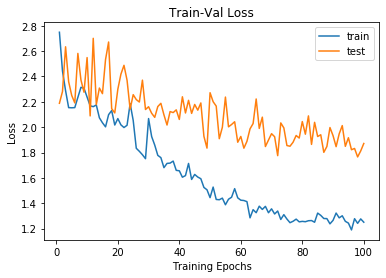

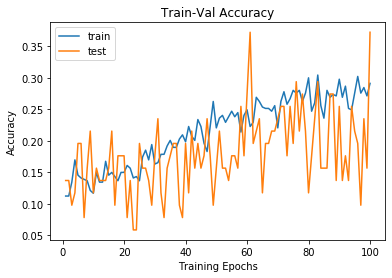

In [99]:
trainutils_leon.plot_loss(loss_hist, metric_hist)